In [73]:
!pip install editdistance

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm
import numpy as np
import editdistance
import Levenshtein
from sklearn.model_selection import train_test_split
from collections import Counter
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision import transforms
import os
import random
from PIL import Image, ImageDraw
import json
from IPython.display import clear_output

from matplotlib import pyplot as plt

In [75]:
import pandas as pd
labels_val = pd.read_csv("/kaggle/input/datada1/archive-3/test.tsv", sep='\t', header=None)
labels_val.rename(columns={0:"file_name", 1:"text"}, inplace=True)

labels_train = pd.read_csv("/kaggle/input/datada1/archive-3/train.tsv", sep='\t', header=None)
labels_train.rename(columns={0:"file_name", 1:"text"}, inplace=True)

labels_train.dropna(inplace=True)
labels_val.dropna(inplace=True)

In [76]:
labels_train

,file_name,text
0,aa1.png,Молдова
1,aa1007.png,продолжила борьбу
2,aa101.png,разработанные
3,aa1012.png,Плачи
4,aa1013.png,Гимны богам
...,...,...
72281,yob20539.png,Ответственность в/сл-
72282,yob20543.png,независимо
72283,yob20544.png,от воинского звания
72284,yob20545.png,воинской


In [77]:
def process_image(img, n_w=256, n_h=64):
    w, h,_ = img.shape
    new_w = n_h
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h,_ = img.shape
    
    if w < n_h:
        add_zeros = np.full((n_h-w, h,3), 0)
        img = np.concatenate((img, add_zeros))
        w, h,_ = img.shape
    
    if h < n_w:
        add_zeros = np.full((w, n_w-h,3), 0)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h,_ = img.shape
        
    if h > n_w or w > n_h:
        dim = (n_w,n_h)
        img = cv2.resize(img, dim)

    return img

def replace_black_to_white(image):
    brown_lo = np.array([0,0,0])
    brown_hi = np.array([0,0,0])

    # Mask image to only select browns
    mask = cv2.inRange(image,brown_lo,brown_hi)

    # Change image to red where we found brown
    image[mask>0] = (255,255,255)
    return image

In [78]:
class ExtraLinesAugmentation:
    '''
    Add random black lines to an image
    Args:
        number_of_lines (int): number of black lines to add
        width_of_lines (int): width of lines
    '''

    def __init__(self, number_of_lines: int = 1, width_of_lines: int = 10):
        self.number_of_lines = number_of_lines
        self.width_of_lines = width_of_lines
      
    def __call__(self, img):
        draw = ImageDraw.Draw(img)
        for _ in range(self.number_of_lines):
            x1 = random.randint(0, np.array(img).shape[1]); y1 = random.randint(0, np.array(img).shape[0])
            x2 = random.randint(0, np.array(img).shape[1]); y2 = random.randint(0, np.array(img).shape[0])
            draw.line((x1, y1, x2 + 100, y2), fill=(100, 0, 0), width=self.width_of_lines)

        return img

In [79]:
def plot_loss_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [80]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


config_json = {
    "alphabet": """@ !"%'()+,-./0123456789:;=?AEFIMNOSTW[]abcdefghiklmnopqrstuvwxyАБВГДЕЖЗИКЛМНОПРСТУХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№""",
    #"alphabet": """@(),-.012345:;?I[]БВГДЗИКМНОПРСТУабвгдежзийклмнопрстуфхцчшщыьэюяё""",
    "save_dir": "/kaggle/working/data/experiments/test",
    "num_epochs": 100,
    #"num_epochs": 500,
    "image": {
        "width": 256,
        "height": 64
    },
    "train": {
        "root_path": "/kaggle/input/datada1/archive-3/train",
        "batch_size": 64
    },
    "val": {
        "root_path": "/kaggle/input/datada1/archive-3/test",
        "batch_size": 128
    }
}

In [81]:
def process_row(text):
    text = text.replace(' ', '|')
    text = list(text)
    for i in range(len(text)):
        if text[i] not in config_json['alphabet'] and text[i] != '|':
            text[i] = '@'
    return " ".join(text)
def prepare_labels(path):
    lines = [line.rstrip() for line in open(path)]
    arr = []
    for line in lines:
        arr.append([line.split('\t')[0], line.split('\t')[1]])
    return arr

In [82]:
def black2white(image):
    lo=np.array([0,0,0])

    hi=np.array([0,0,0])

    mask = cv2.inRange(image, lo, hi)

    image[mask>0]=(255,255,255)

    return image

In [83]:
# функция которая помогает объединять картинки и таргет-текст в батч
def collate_fn(batch):
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0)
    text_lens = torch.LongTensor([len(text) for text in texts])
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens
def collate_fn_val(batch):
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0)
    text_lens = torch.LongTensor([len(text) for text in texts])
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens


def get_data_loader(
    transforms, df, root_path, tokenizer, batch_size, drop_last, config, train, shuffle=False
):
    dataset = OCRDataset(df, root_path, tokenizer, config, train, transforms)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        num_workers=4,
        shuffle=shuffle
    )
    return data_loader

def get_data_loader_val(
    transforms, df, root_path, tokenizer, batch_size, drop_last, config, train, shuffle=False
):
    dataset = OCRDataset(df, root_path, tokenizer, config, train, transforms)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        collate_fn=collate_fn_val,
        batch_size=batch_size,
        num_workers=4,
        shuffle=shuffle
    )
    return data_loader

def prepare_val_image(image, transform1, transform2):
    image3 = image.astype(np.uint8)
    image3 = Image.fromarray(image3)
    image3 = transform1(image3)
    image3 = np.array(image3).astype(np.int64)
    image3 = transform2(image3)
    return image3

class OCRDataset(Dataset):
    
    def __init__(self, df, root_path, tokenizer, config, train=False, transform=None):
        super().__init__()
        self.transform = transform
        self.config = config
        self.df = df
        self.data_len = len(self.df)
        self.train = train
        self.train_transform = transforms.Compose([
            ExtraLinesAugmentation(number_of_lines=3,
                                   width_of_lines=8),                         
            transforms.RandomAffine(degrees=0,
                                    scale=(0.935, 0.935)),
                                    #fill=0),
                                    #fillcolor=0),
            transforms.RandomCrop((self.config['image']['height'], self.config['image']['width'])),
            transforms.RandomRotation(degrees=(-12, 12),
                                      fill=255),])
        self.img_paths = []
        self.texts = []
        for i in range(self.data_len):
            self.img_paths.append(os.path.join(root_path, self.df['file_name'].iloc[i]))
            self.texts.append(self.df['text'].iloc[i])
        '''
        for text in self.texts:
            try:
                tokenizer.encode(text)
            except Exception as e:
                print(e)
                print(text)'''
        self.enc_texts = tokenizer.encode(self.texts)
        
    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        text = self.texts[idx]
        enc_len = 32
        enc_text = self.enc_texts[idx][:enc_len]
        enc_text = enc_text + [0] * (enc_len - len(enc_text))
        enc_text = torch.LongTensor(enc_text)
        image = black2white(cv2.imread(img_path))
        
        if self.train:
            #image = self.blots(image)
            image = process_image(image,
                                  int(self.config['image']['width'] * 1.05),
                                  int(self.config['image']['height'] * 1.05))
            
            image = image.astype(np.uint8)
            image = Image.fromarray(image)
            image = self.train_transform(image)
            image = np.array(image).astype(np.int64)
        else:
            image = process_image(image, self.config['image']['width'], self.config['image']['height'])
        if self.transform is not None:
            image = self.transform(image)
        if self.train:
            image = image ** (random.random() * 0.7 + 0.6)
        if self.train == False:
            return image, text, enc_text
        else:
            return image, text, enc_text


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [84]:
CTC_BLANK = '<BLANK>'

def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 1 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else 1
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[CTC_BLANK]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words
    def decode_after_beam(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

In [85]:
def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

In [86]:
class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img


class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr


class MoveChannels:
    """Move the channel axis to the zero position as required in pytorch."""

    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)


class ImageResize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, image):
        image = cv2.resize(image, (self.width, self.height),
                           interpolation=cv2.INTER_LINEAR)
        return image



def get_train_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        #ImageResize(height, width),
        
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms


def get_val_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        #ImageResize(height, width),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms

In [87]:
def get_resnet34_backbone(pretrained=True):
    m = torchvision.models.resnet34(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)
def get_resnet50_backbone(pretrained=True):
    m = torchvision.models.resnet50(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

In [88]:
class CRNN_RESNET(nn.Module):
    def __init__(
        self, number_class_symbols, out_len=32
    ):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(pretrained=True)
        # веса resnet34 получаются из этого гитхаба https://github.com/lolpa1n/digital-peter-ocrv 
        #self.feature_extractor.load_state_dict(torch.load('../input/ocr-resnet/resnet_ocr.pt')) 
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (512, out_len))
        self.bilstm = BiLSTM(512, 256, 2)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, number_class_symbols)
        )
    def forward(self, x, return_x=False):
        feature = self.feature_extractor(x)
        b, c, h, w = feature.size()
        feature = feature.view(b, c * h, w)
        feature = self.avg_pool(feature)
        feature = feature.transpose(1, 2)
        out = self.bilstm(feature)
        #print(x.shape)
        out = self.classifier(out)
        

        x1 = nn.functional.log_softmax(out, dim=2).permute(1, 0, 2)
        if return_x:
            return x1, out
        else:
            return x1

In [89]:
from copy import deepcopy

def val_loop(data_loader, model, criterion, tokenizer, device):
    acc_avg = AverageMeter()
    loss_avg = AverageMeter()
    error_chars = 0
    error_words = 0
    criterion2 = nn.CrossEntropyLoss()
    total_string = 0
    ctc_weight = 0.9
    for images, texts, enc_pad_texts, text_lens in tqdm(data_loader):
        #print("мы зашли в цикл")
        batch_size = len(texts)
        enc_pad_texts2 = deepcopy(enc_pad_texts.view(-1)).cuda()
        text_preds, output, output2 = predict(images, model, tokenizer, device, return_output=True)
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )
        try:
            loss1 = criterion(output, enc_pad_texts, output_lenghts, text_lens).mean()
        except Exception as e:
            #print(f"val: {e}")
            continue
        output2 = output2.view(output2.shape[0] * output2.shape[1], output2.shape[2])
        loss2 = criterion2(output2,
                           enc_pad_texts2)
        loss = ctc_weight * loss1 + (1.0 - ctc_weight) * loss2
        loss_avg.update(loss.item(), batch_size)
        for i in range(batch_size):
            total_string += 1
            error_chars += (editdistance.eval(text_preds[i], texts[i]) / len(texts[i]))
            words_text_preds = text_preds[i].split()
            words_texts = texts[i].split()
            error_words += Levenshtein.distance(words_text_preds, words_texts) / len(words_texts)
            '''
            if text_preds[i] != texts[i]:
                print('----------------')
                print(f'true: {texts[i]}')
                print(f'pred: {text_preds[i]}')
            '''
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
    print(f"Val loss average: {loss_avg.avg}")
    print(f'Validation, acc: {acc_avg.avg:.4f}')
    print(f"CER: {error_chars / total_string * 100}%")
    print(f"WER: {error_words / total_string * 100}%")
    #loss, cer, wer, acc
    return loss_avg.avg, error_chars / total_string, error_words / total_string, acc_avg.avg

def train_loop(data_loader, model, criterion, optimizer, epoch, train_history=[]):
    loss_avg = AverageMeter()
    model.train()
    criterion2 = nn.CrossEntropyLoss()
    ctc_weight = 0.9
    i = 0
    for images, texts, enc_pad_texts, text_lens in tqdm(data_loader):
        model.zero_grad()
        images = images.to(DEVICE)
        enc_pad_texts2 = deepcopy(enc_pad_texts.view(-1)).cuda()
        batch_size = len(texts)
        output, output2 = model(images, True)
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )
        #print(output.permute(1, 0, 2).shape, enc_pad_texts.shape)
        #enc_pad_texts2 = []
        #second_loss = criterion2(output.permute(1, 0, 2), enc_pad_texts)
        enc_pad_texts = enc_pad_texts.flatten()  # make 1dim, the doc says we can do it
        enc_pad_texts = enc_pad_texts[enc_pad_texts != 0]  # drop blank dims
        try:
            loss1 = criterion(output, enc_pad_texts, output_lenghts, text_lens).mean()#(criterion(output, enc_pad_texts, output_lenghts, text_lens).mean() + second_loss) / 2
        except Exception as e:
            #print(f"train: {e}")
            continue
        output2 = output2.view(output2.shape[0] * output2.shape[1], output2.shape[2])
        loss2 = criterion2(output2, enc_pad_texts2)
        loss = ctc_weight * loss1 + (1.0 - ctc_weight) * loss2    
        loss_avg.update(loss.item(), batch_size)
        train_history.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
        if i % 100 == 0:
            print('train_loss =', loss)
        i += 1
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    return loss_avg.avg, train_history


def predict(images, model, tokenizer, device, return_output=False):
    model.eval()
    images = images.to(device)
    #print(images.shape)
    with torch.no_grad():
        output, output2 = model(images, True)
    #output = process_output(output)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    if return_output:
        return text_preds, output, output2
    else:
        return text_preds


def get_loaders(tokenizer, config, labels_train, labels_val):
    train_transforms = get_train_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    train_loader = get_data_loader(
        df=labels_train,
        root_path=config['train']['root_path'],
        transforms=train_transforms,
        tokenizer=tokenizer,
        batch_size=config['train']['batch_size'],
        drop_last=True,
        config=config,
        train=True,
        shuffle=True

    )
    val_transforms = get_val_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    val_loader = get_data_loader_val(
        df=labels_val,
        transforms=val_transforms,
        root_path=config['val']['root_path'],
        tokenizer=tokenizer,
        batch_size=config['val']['batch_size'],
        drop_last=False,
        config=config,
        train=False,
        shuffle=False
    )
    return train_loader, val_loader


In [90]:
tokenizer = Tokenizer(config_json['alphabet'])
os.makedirs(config_json['save_dir'], exist_ok=True)
train_loader, val_loader = get_loaders(tokenizer, config_json, labels_train, labels_val)

In [91]:
tokenizer.get_num_chars()

124

In [92]:
model = CRNN_RESNET(tokenizer.get_num_chars(), 32)
model.to(DEVICE)
model.eval()

CRNN_RESNET(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [93]:
criterion = torch.nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,
                                  weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode='min', factor=0.5, patience=2)

In [94]:
import warnings
warnings.filterwarnings("ignore")

Current CER = 0.33362848230118786
Current WER = 0.8881152849740934
Current loss = 11.368099756191432
Current acc_avg = 0.0822538860103627
Current learning rate = 0.001
--------------------
Best CER = 0.33362848230118786
Best WER = 0.8881152849740934
Best loss = 11.368099756191432
Best epoch = 2


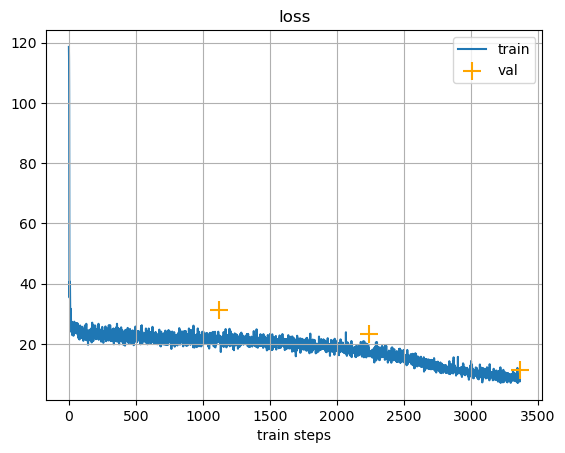

num of epoch 3


  0%|          | 0/1130 [00:00<?, ?it/s]

train_loss = tensor(8.7214, device='cuda:0', grad_fn=<AddBackward0>)
train_loss = tensor(6.6532, device='cuda:0', grad_fn=<AddBackward0>)
train_loss = tensor(7.6632, device='cuda:0', grad_fn=<AddBackward0>)
train_loss = tensor(8.8819, device='cuda:0', grad_fn=<AddBackward0>)
train_loss = tensor(7.8313, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
best_cer = np.inf
best_wer = np.inf
best_loss = np.inf
best_epoch = 0
train_history = []
val_history = []
val_loop(val_loader, model, criterion, tokenizer, DEVICE)
for epoch in tqdm(range(config_json['num_epochs'])):
    print("num of epoch", epoch)
    loss_avg, train_history = train_loop(train_loader, model, criterion, optimizer, epoch, train_history)
    print('average_train_loss', loss_avg)
    val_loss_avg, cer_avg, wer_avg, acc_avg = val_loop(val_loader, model, criterion, tokenizer, DEVICE)
    val_history.append(val_loss_avg)
    scheduler.step(cer_avg)
    if cer_avg < best_cer:
        best_cer = cer_avg
        best_wer = wer_avg
        best_epoch = epoch
        best_loss = val_loss_avg
        model_save_path = os.path.join(
            config_json['save_dir'], f'model-{epoch}-{cer_avg:.4f}.ckpt')
        torch.save(model.state_dict(), model_save_path)
        print('Model weights saved')
    clear_output()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'Current CER = {cer_avg}')
    print(f'Current WER = {wer_avg}')
    print(f'Current loss = {val_loss_avg}')
    print(f'Current acc_avg = {acc_avg}')
    print(f'Current learning rate = {lr}')
    print('-' * 20)
    print(f'Best CER = {best_cer}')
    print(f'Best WER = {best_wer}')
    print(f'Best loss = {best_loss}')
    print(f'Best epoch = {best_epoch}')
    plot_loss_history(train_history, val_history)